### LychSim 3D Ground Truth Demo

In [1]:
import io

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from lychsim.api import Client

client = Client(('localhost', 9000))
client.connect()

print(client.request('vget /unrealcv/status'))

INFO:client:235:Got connection confirm: b'connected to MyProject5'


=>Info: using ip-port socket
Is Listening
Client Connected
9000
Configuration
Config file: C:/Program Files/Epic Games/UE_5.5/Engine/Binaries/Win64/unrealcv.ini
Port: 9000
Width: 1920
Height: 1080
FOV: 90.000000
EnableInput: true
EnableRightEye: false



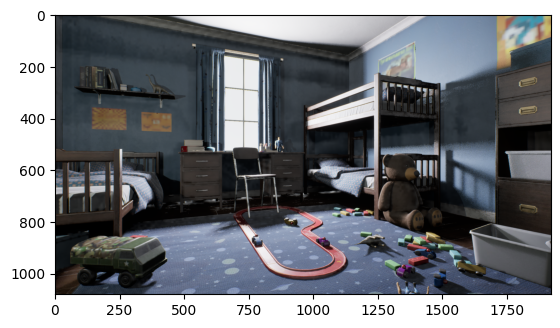

In [2]:
def get_rgba():
    res = client.request('vget /camera/1/lit png')
    return np.array(Image.open(io.BytesIO(res)))

img = get_rgba()
plt.imshow(img)

In [3]:
def get_aabb(object_name):
    res = client.request(f'lych object get_aabb {object_name}')
    res = [float(x) for x in res.strip().split(' ')]
    return np.array(res[:3]), np.array(res[3:])

def get_corners(center, extent):
    corners = np.array([
        [-1, -1, -1],
        [1, -1, -1],
        [1, 1, -1],
        [-1, 1, -1],
        [-1, -1, 1],
        [1, -1, 1],
        [1, 1, 1],
        [-1, 1, 1],
    ])
    edges = np.array([
        [0, 1], [1, 2], [2, 3], [3, 0],
        [4, 5], [5, 6], [6, 7], [7, 4],
        [0, 4], [1, 5], [2, 6], [3, 7],
    ])
    corners = corners * extent
    corners = corners + center
    return corners, edges

object_name = 'SM_Toy_teddy_178'
center, extent = get_aabb(object_name)
corners, edges = get_corners(center, extent)
print('Center:', center)
print('Extent:', extent)
print('Corners:', corners)

Center: [ 134.427 1043.409   35.257]
Extent: [25.521 28.202 35.447]
Corners: [[ 1.089060e+02  1.015207e+03 -1.900000e-01]
 [ 1.599480e+02  1.015207e+03 -1.900000e-01]
 [ 1.599480e+02  1.071611e+03 -1.900000e-01]
 [ 1.089060e+02  1.071611e+03 -1.900000e-01]
 [ 1.089060e+02  1.015207e+03  7.070400e+01]
 [ 1.599480e+02  1.015207e+03  7.070400e+01]
 [ 1.599480e+02  1.071611e+03  7.070400e+01]
 [ 1.089060e+02  1.071611e+03  7.070400e+01]]


In [4]:
def get_c2w():
    res = client.request('lych cam get_c2w 1')
    res = [float(x) for x in res.strip().split(' ')]
    return np.array(res).reshape(4, 4)

c2w = get_c2w()
print('Camera to World:\n', c2w)

Camera to World:
 [[-9.13545e-01  4.06737e-01  0.00000e+00  3.20000e+02]
 [-4.06737e-01 -9.13545e-01  0.00000e+00  1.24000e+03]
 [ 0.00000e+00 -0.00000e+00  1.00000e+00  7.00000e+01]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]


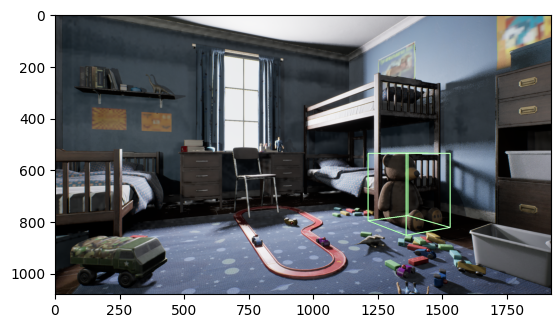

In [7]:
def get_fov():
    res = client.request('lych cam get_fov 1')
    return float(res.strip())

def fx_fy_from_fovx(fovx_deg, W, H):
    fovx = np.deg2rad(fovx_deg)
    fx = 0.5 * W / np.tan(0.5 * fovx)
    fovy = 2.0 * np.arctan((H / float(W)) * np.tan(0.5 * fovx))
    fy = 0.5 * H / np.tan(0.5 * fovy)
    return fx, fy

def project(corners, c2w, fov):
    w2c = np.linalg.inv(c2w)
    pts_h = np.concatenate([corners, np.ones((corners.shape[0], 1))], axis=1)
    pc = (w2c @ pts_h.T).T
    Xc, Yc, Zc = pc[:,0], pc[:,1], pc[:,2]

    in_front = Xc > 0

    fx, fy = fx_fy_from_fovx(fov, W, H)
    cx, cy = 0.5 * W, 0.5 * H

    u = fx * (Yc / Xc) + cx
    v = fy * (-Zc / Xc) + cy

    uv = np.stack([u, v], axis=-1).reshape(-1, 2)
    in_front = in_front.reshape(corners.shape[:-1])
    return uv, in_front

def visualize_bbox(img, corners_2d, edges, color=(0, 255, 0), thickness=2):
    for i, j in edges:
        pt1 = (int(corners_2d[i, 0]), int(corners_2d[i, 1]))
        pt2 = (int(corners_2d[j, 0]), int(corners_2d[j, 1]))
        cv2.line(img, pt1, pt2, color, thickness)
    plt.imshow(img)

fov = get_fov()
H, W = img.shape[:2]
pts2d, _ = project(corners, c2w, fov)
visualize_bbox(img.copy(), pts2d, edges)